In [ ]:
#import necessary packages
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

from tqdm.auto import tqdm
import matplotlib.pyplot as plt


### **1) Import Dataset and preprocess images.**






In [ ]:

!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd
#import data from kaggle


od.download('https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bethjane398
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri


100%|██████████| 86.8M/86.8M [00:00<00:00, 116MB/s]


In [ ]:
#resize images for input size for neural networks, augment images.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), #resizing images to 224x224
    transforms.ToTensor(),          #convert images to tensor
    transforms.RandomRotation(45),   #Randomly rotate by 45 degrees
    transforms.RandomHorizontalFlip(),  #randomly flip horizontally
     transforms.ColorJitter(brightness=0.4),  #change brightness randomly
])

#for testing set
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [ ]:

train_dataset = datasets.ImageFolder("/content/brain-tumor-classification-mri/Training", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/brain-tumor-classification-mri/Testing", transform= test_transform)

# ( 90% train, 10% evaluation)
train_ratio = 0.9
val_ratio = 1 - train_ratio


train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 2870 samples
Train set has 2583 samples
Validation set has 287 samples
Test set has 394 samples


In [ ]:
batch_size = 20

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

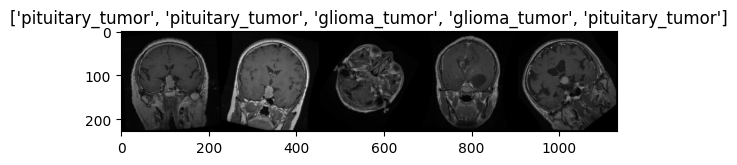

In [ ]:

#show samples of images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

out = torchvision.utils.make_grid(inputs)

class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

imshow(out, title=[class_names[x] for x in classes])



In [ ]:
class_names=train_dataset.classes
print(class_names)
print(len(class_names))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
4


### **2) CNN model**



In [ ]:
import torch.nn as nn

#model definition
class MyCNN(nn.Module):

 # Convolution Neural network for brain tumour classification
 # Three convoltion layers, each followed by a ReLU layer and Max pooling layer


    def __init__(self):
        super(MyCNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 14 * 14, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc_layers(x)
        return x


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MyCNN()
model = model.to(device)

In [ ]:
#define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)


In [ ]:

#model training
import torch
import torch.nn as nn
from tqdm import tqdm

n_epochs = 60
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):
    model.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Ensure input images have a single channel
        imgs = imgs[:, :1, :, :]

        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

#evaluation
    model.eval()
    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)


        imgs = imgs[:, :1, :, :]

        with torch.no_grad():
            logits = model(imgs)

        loss = criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")


100%|██████████| 15/15 [00:02<00:00,  5.99it/s]


[Epoch: 001/005] Train: loss=1.06454, acc=0.50974 | Valid: loss=0.89326, acc=0.58762


100%|██████████| 15/15 [00:02<00:00,  6.02it/s]


[Epoch: 002/005] Train: loss=0.87620, acc=0.61654 | Valid: loss=0.74471, acc=0.69762


100%|██████████| 15/15 [00:02<00:00,  5.93it/s]


[Epoch: 003/005] Train: loss=0.76427, acc=0.65538 | Valid: loss=0.71202, acc=0.71095


100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


[Epoch: 004/005] Train: loss=0.72575, acc=0.66705 | Valid: loss=0.71236, acc=0.68286


100%|██████████| 15/15 [00:02<00:00,  6.10it/s]


[Epoch: 005/005] Train: loss=0.68557, acc=0.69410 | Valid: loss=0.61161, acc=0.73429


### **3) CNN Model Evaluation**

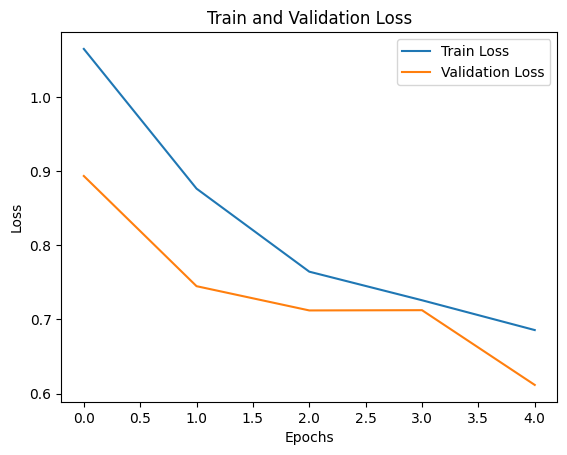

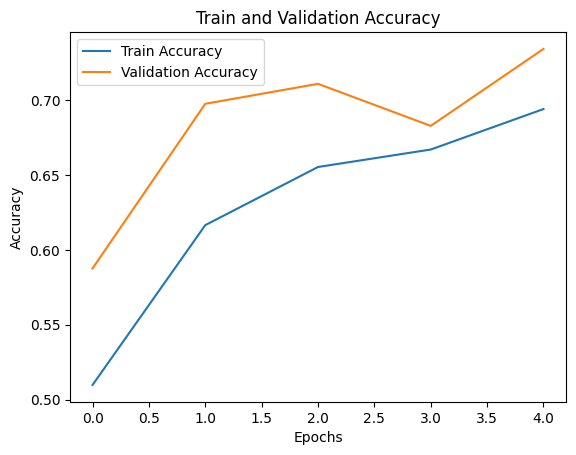

In [ ]:
#plot training and evaluation loss
plt.figure()
plt.plot(train_loss_epochs, label = "Train Loss")
plt.plot(valid_loss_epochs, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.show()
#plot training and evaluation accuracy
plt.figure()
plt.plot(train_acc_epochs, label = "Train Accuracy")
plt.plot(valid_acc_epochs, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.show()

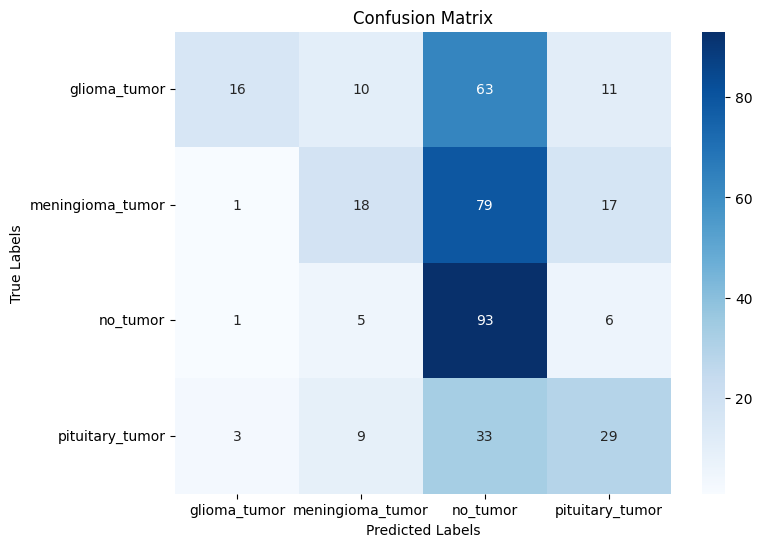

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = []
y_pred_classes = []

for batch in test_loader:
    imgs, labels = batch
    imgs_gray = torch.mean(imgs, dim=1, keepdim=True)
    imgs_gray = imgs_gray.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        logits = model(imgs_gray)
    pred_classes = logits.argmax(dim=-1)
    class_labels.extend(labels.cpu().numpy())
    y_pred_classes.extend(pred_classes.cpu().numpy())

conf_matrix = confusion_matrix(class_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



### **4) AlexNet model**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

#import alexnet model, altering it to take in 1 channel due to black and white images, and have an output of 4 due to 4 classifications.
alexnet_model = models.alexnet(pretrained=True)

alexnet_model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)

alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, 4)

for param in alexnet_model.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(alexnet_model.parameters(), lr=0.0003)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = alexnet_model.to(device)



Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 87.6MB/s]


In [ ]:
#train alexnet model.
mport torch
import torch.nn as nn
from tqdm import tqdm

n_epochs = 100
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):
    alexnet_model.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        imgs = imgs[:, :1, :, :]

        logits = alexnet_model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    alexnet_model.eval()
    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)


        imgs = imgs[:, :1, :, :]

        with torch.no_grad():
            logits = alexnet_model(imgs)

        loss = criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(alexnet_model.state_dict(), 'best_alexnet_model.pth')

    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")


100%|██████████| 15/15 [00:02<00:00,  6.88it/s]


[Epoch: 001/100] Train: loss=1.12733, acc=0.49282 | Valid: loss=0.92737, acc=0.60476


100%|██████████| 15/15 [00:02<00:00,  6.79it/s]


[Epoch: 002/100] Train: loss=0.97707, acc=0.55936 | Valid: loss=0.90234, acc=0.60429


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


[Epoch: 003/100] Train: loss=0.91303, acc=0.59846 | Valid: loss=0.86881, acc=0.60905


100%|██████████| 15/15 [00:02<00:00,  5.83it/s]


[Epoch: 004/100] Train: loss=0.87962, acc=0.60577 | Valid: loss=0.86647, acc=0.61476


100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


[Epoch: 005/100] Train: loss=0.86165, acc=0.60321 | Valid: loss=0.84207, acc=0.64143


100%|██████████| 15/15 [00:02<00:00,  6.62it/s]


[Epoch: 006/100] Train: loss=0.86422, acc=0.60641 | Valid: loss=0.78760, acc=0.65762


100%|██████████| 15/15 [00:02<00:00,  6.70it/s]


[Epoch: 007/100] Train: loss=0.85245, acc=0.61115 | Valid: loss=0.83516, acc=0.63381


100%|██████████| 15/15 [00:02<00:00,  6.70it/s]


[Epoch: 008/100] Train: loss=0.82380, acc=0.62808 | Valid: loss=0.77623, acc=0.64810


100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


[Epoch: 009/100] Train: loss=0.82033, acc=0.63551 | Valid: loss=0.85871, acc=0.61143


100%|██████████| 15/15 [00:02<00:00,  6.76it/s]


[Epoch: 010/100] Train: loss=0.81321, acc=0.63782 | Valid: loss=0.74211, acc=0.69810


100%|██████████| 15/15 [00:02<00:00,  6.64it/s]


[Epoch: 011/100] Train: loss=0.80641, acc=0.64692 | Valid: loss=0.75840, acc=0.66714


100%|██████████| 15/15 [00:02<00:00,  5.64it/s]


[Epoch: 012/100] Train: loss=0.80438, acc=0.64372 | Valid: loss=0.66856, acc=0.69810


100%|██████████| 15/15 [00:03<00:00,  4.96it/s]


[Epoch: 013/100] Train: loss=0.80367, acc=0.63936 | Valid: loss=0.71717, acc=0.67667


100%|██████████| 15/15 [00:02<00:00,  5.80it/s]


[Epoch: 014/100] Train: loss=0.76783, acc=0.64436 | Valid: loss=0.75039, acc=0.66143


100%|██████████| 15/15 [00:02<00:00,  6.99it/s]


[Epoch: 015/100] Train: loss=0.76868, acc=0.64936 | Valid: loss=0.73685, acc=0.67429


100%|██████████| 15/15 [00:02<00:00,  6.96it/s]


[Epoch: 016/100] Train: loss=0.76026, acc=0.65923 | Valid: loss=0.70567, acc=0.69714


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


[Epoch: 017/100] Train: loss=0.74502, acc=0.66705 | Valid: loss=0.75519, acc=0.61429


100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


[Epoch: 018/100] Train: loss=0.76179, acc=0.66231 | Valid: loss=0.69300, acc=0.65476


100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


[Epoch: 019/100] Train: loss=0.74199, acc=0.67462 | Valid: loss=0.69992, acc=0.68524


100%|██████████| 15/15 [00:02<00:00,  6.79it/s]


[Epoch: 020/100] Train: loss=0.73756, acc=0.67808 | Valid: loss=0.65191, acc=0.70762


100%|██████████| 15/15 [00:02<00:00,  6.80it/s]


[Epoch: 021/100] Train: loss=0.74132, acc=0.67167 | Valid: loss=0.70930, acc=0.68667


100%|██████████| 15/15 [00:02<00:00,  6.96it/s]


[Epoch: 022/100] Train: loss=0.73752, acc=0.69436 | Valid: loss=0.71032, acc=0.69143


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


[Epoch: 023/100] Train: loss=0.72851, acc=0.65603 | Valid: loss=0.66107, acc=0.70190


100%|██████████| 15/15 [00:02<00:00,  6.13it/s]


[Epoch: 024/100] Train: loss=0.73823, acc=0.67500 | Valid: loss=0.64622, acc=0.71143


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


[Epoch: 025/100] Train: loss=0.71216, acc=0.68808 | Valid: loss=0.66706, acc=0.73762


100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


[Epoch: 026/100] Train: loss=0.72475, acc=0.67179 | Valid: loss=0.68716, acc=0.68095


100%|██████████| 15/15 [00:02<00:00,  6.73it/s]


[Epoch: 027/100] Train: loss=0.70762, acc=0.69154 | Valid: loss=0.69470, acc=0.66810


100%|██████████| 15/15 [00:02<00:00,  6.66it/s]


[Epoch: 028/100] Train: loss=0.71074, acc=0.69244 | Valid: loss=0.67127, acc=0.71143


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


[Epoch: 029/100] Train: loss=0.71514, acc=0.68731 | Valid: loss=0.66556, acc=0.70762


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


[Epoch: 030/100] Train: loss=0.71995, acc=0.68321 | Valid: loss=0.61559, acc=0.73381


100%|██████████| 15/15 [00:02<00:00,  6.98it/s]


[Epoch: 031/100] Train: loss=0.69523, acc=0.67821 | Valid: loss=0.68604, acc=0.69524


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


[Epoch: 032/100] Train: loss=0.70992, acc=0.69192 | Valid: loss=0.67506, acc=0.68762


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


[Epoch: 033/100] Train: loss=0.69423, acc=0.69808 | Valid: loss=0.69710, acc=0.70714


100%|██████████| 15/15 [00:02<00:00,  6.88it/s]


[Epoch: 034/100] Train: loss=0.68473, acc=0.68538 | Valid: loss=0.66292, acc=0.72048


100%|██████████| 15/15 [00:02<00:00,  6.75it/s]


[Epoch: 035/100] Train: loss=0.68761, acc=0.69167 | Valid: loss=0.60759, acc=0.72429


100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


[Epoch: 036/100] Train: loss=0.67399, acc=0.70962 | Valid: loss=0.63507, acc=0.72095


100%|██████████| 15/15 [00:02<00:00,  6.99it/s]


[Epoch: 037/100] Train: loss=0.67946, acc=0.69679 | Valid: loss=0.60876, acc=0.73810


100%|██████████| 15/15 [00:02<00:00,  6.07it/s]


[Epoch: 038/100] Train: loss=0.65774, acc=0.71385 | Valid: loss=0.61007, acc=0.72667


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


[Epoch: 039/100] Train: loss=0.67547, acc=0.69846 | Valid: loss=0.63733, acc=0.71429


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


[Epoch: 040/100] Train: loss=0.67592, acc=0.71423 | Valid: loss=0.60020, acc=0.70714


100%|██████████| 15/15 [00:02<00:00,  5.85it/s]


[Epoch: 041/100] Train: loss=0.69700, acc=0.68987 | Valid: loss=0.59604, acc=0.77667


100%|██████████| 15/15 [00:02<00:00,  6.71it/s]


[Epoch: 042/100] Train: loss=0.65613, acc=0.70936 | Valid: loss=0.59264, acc=0.73429


100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


[Epoch: 043/100] Train: loss=0.66617, acc=0.70756 | Valid: loss=0.60521, acc=0.76000


100%|██████████| 15/15 [00:02<00:00,  6.80it/s]


[Epoch: 044/100] Train: loss=0.65860, acc=0.71641 | Valid: loss=0.57680, acc=0.74095


100%|██████████| 15/15 [00:02<00:00,  6.80it/s]


[Epoch: 045/100] Train: loss=0.65577, acc=0.72013 | Valid: loss=0.63478, acc=0.72762


100%|██████████| 15/15 [00:02<00:00,  6.92it/s]


[Epoch: 046/100] Train: loss=0.66152, acc=0.71769 | Valid: loss=0.63187, acc=0.71429


100%|██████████| 15/15 [00:02<00:00,  6.92it/s]


[Epoch: 047/100] Train: loss=0.63079, acc=0.71308 | Valid: loss=0.60100, acc=0.75762


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


[Epoch: 048/100] Train: loss=0.64059, acc=0.72000 | Valid: loss=0.59503, acc=0.73048


100%|██████████| 15/15 [00:02<00:00,  6.74it/s]


[Epoch: 049/100] Train: loss=0.64759, acc=0.71590 | Valid: loss=0.59169, acc=0.74476


100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


[Epoch: 050/100] Train: loss=0.62485, acc=0.73321 | Valid: loss=0.57989, acc=0.76048


100%|██████████| 15/15 [00:02<00:00,  6.62it/s]


[Epoch: 051/100] Train: loss=0.65474, acc=0.70936 | Valid: loss=0.61126, acc=0.73429


100%|██████████| 15/15 [00:02<00:00,  5.69it/s]


[Epoch: 052/100] Train: loss=0.63122, acc=0.72436 | Valid: loss=0.58258, acc=0.75333


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


[Epoch: 053/100] Train: loss=0.62872, acc=0.73269 | Valid: loss=0.60033, acc=0.74429


100%|██████████| 15/15 [00:02<00:00,  5.44it/s]


[Epoch: 054/100] Train: loss=0.63755, acc=0.72385 | Valid: loss=0.60771, acc=0.73429


100%|██████████| 15/15 [00:02<00:00,  5.80it/s]


[Epoch: 055/100] Train: loss=0.64574, acc=0.71731 | Valid: loss=0.57068, acc=0.73762


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


[Epoch: 056/100] Train: loss=0.64538, acc=0.72205 | Valid: loss=0.61461, acc=0.74476


100%|██████████| 15/15 [00:02<00:00,  6.80it/s]


[Epoch: 057/100] Train: loss=0.63937, acc=0.72615 | Valid: loss=0.57651, acc=0.76190


100%|██████████| 15/15 [00:02<00:00,  6.94it/s]


[Epoch: 058/100] Train: loss=0.62719, acc=0.73436 | Valid: loss=0.58455, acc=0.75762


100%|██████████| 15/15 [00:02<00:00,  7.00it/s]


[Epoch: 059/100] Train: loss=0.64329, acc=0.71744 | Valid: loss=0.52288, acc=0.77143


100%|██████████| 15/15 [00:02<00:00,  7.02it/s]


[Epoch: 060/100] Train: loss=0.61548, acc=0.71936 | Valid: loss=0.59767, acc=0.77714


100%|██████████| 15/15 [00:02<00:00,  6.91it/s]


[Epoch: 061/100] Train: loss=0.62910, acc=0.72808 | Valid: loss=0.58627, acc=0.75571


100%|██████████| 15/15 [00:02<00:00,  6.94it/s]


[Epoch: 062/100] Train: loss=0.62951, acc=0.72051 | Valid: loss=0.53358, acc=0.77714


100%|██████████| 15/15 [00:02<00:00,  6.91it/s]


[Epoch: 063/100] Train: loss=0.61043, acc=0.73269 | Valid: loss=0.63310, acc=0.73905


100%|██████████| 15/15 [00:02<00:00,  6.99it/s]


[Epoch: 064/100] Train: loss=0.63383, acc=0.72359 | Valid: loss=0.58630, acc=0.76095


100%|██████████| 15/15 [00:02<00:00,  6.17it/s]


[Epoch: 065/100] Train: loss=0.61775, acc=0.72013 | Valid: loss=0.55730, acc=0.74810


100%|██████████| 15/15 [00:02<00:00,  5.34it/s]


[Epoch: 066/100] Train: loss=0.60853, acc=0.72436 | Valid: loss=0.51858, acc=0.77048


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


[Epoch: 067/100] Train: loss=0.62349, acc=0.73500 | Valid: loss=0.56636, acc=0.73714


100%|██████████| 15/15 [00:02<00:00,  6.71it/s]


[Epoch: 068/100] Train: loss=0.60176, acc=0.74769 | Valid: loss=0.55972, acc=0.76429


100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


[Epoch: 069/100] Train: loss=0.61412, acc=0.72564 | Valid: loss=0.53467, acc=0.79095


100%|██████████| 15/15 [00:02<00:00,  6.79it/s]


[Epoch: 070/100] Train: loss=0.62705, acc=0.72308 | Valid: loss=0.56745, acc=0.78048


100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


[Epoch: 071/100] Train: loss=0.61274, acc=0.73013 | Valid: loss=0.55666, acc=0.76381


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


[Epoch: 072/100] Train: loss=0.59715, acc=0.73256 | Valid: loss=0.58371, acc=0.73810


100%|██████████| 15/15 [00:02<00:00,  6.67it/s]


[Epoch: 073/100] Train: loss=0.60404, acc=0.73282 | Valid: loss=0.50193, acc=0.81714


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


[Epoch: 074/100] Train: loss=0.60222, acc=0.74974 | Valid: loss=0.54664, acc=0.78429


100%|██████████| 15/15 [00:02<00:00,  6.39it/s]


[Epoch: 075/100] Train: loss=0.60026, acc=0.74154 | Valid: loss=0.55042, acc=0.74714


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


[Epoch: 076/100] Train: loss=0.58701, acc=0.74769 | Valid: loss=0.57443, acc=0.75095


100%|██████████| 15/15 [00:02<00:00,  6.79it/s]


[Epoch: 077/100] Train: loss=0.59746, acc=0.75167 | Valid: loss=0.52588, acc=0.75476


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


[Epoch: 078/100] Train: loss=0.61488, acc=0.72718 | Valid: loss=0.53573, acc=0.76095


100%|██████████| 15/15 [00:02<00:00,  6.97it/s]


[Epoch: 079/100] Train: loss=0.60190, acc=0.73192 | Valid: loss=0.50580, acc=0.79000


100%|██████████| 15/15 [00:02<00:00,  6.92it/s]


[Epoch: 080/100] Train: loss=0.59808, acc=0.74205 | Valid: loss=0.53202, acc=0.76143


100%|██████████| 15/15 [00:02<00:00,  6.77it/s]


[Epoch: 081/100] Train: loss=0.58788, acc=0.75667 | Valid: loss=0.52204, acc=0.78381


100%|██████████| 15/15 [00:02<00:00,  6.73it/s]


[Epoch: 082/100] Train: loss=0.57083, acc=0.75077 | Valid: loss=0.56592, acc=0.77095


100%|██████████| 15/15 [00:02<00:00,  5.83it/s]


[Epoch: 083/100] Train: loss=0.60089, acc=0.74436 | Valid: loss=0.58843, acc=0.72095


100%|██████████| 15/15 [00:02<00:00,  5.16it/s]


[Epoch: 084/100] Train: loss=0.58742, acc=0.74538 | Valid: loss=0.50751, acc=0.76381


100%|██████████| 15/15 [00:02<00:00,  5.90it/s]


[Epoch: 085/100] Train: loss=0.57584, acc=0.75179 | Valid: loss=0.53368, acc=0.79333


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


[Epoch: 086/100] Train: loss=0.58585, acc=0.74808 | Valid: loss=0.54926, acc=0.80714


100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


[Epoch: 087/100] Train: loss=0.56787, acc=0.75462 | Valid: loss=0.53276, acc=0.81381


100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


[Epoch: 088/100] Train: loss=0.58888, acc=0.73936 | Valid: loss=0.53018, acc=0.80381


100%|██████████| 15/15 [00:02<00:00,  6.84it/s]


[Epoch: 089/100] Train: loss=0.55856, acc=0.75667 | Valid: loss=0.51598, acc=0.77762


100%|██████████| 15/15 [00:02<00:00,  6.77it/s]


[Epoch: 090/100] Train: loss=0.57784, acc=0.74936 | Valid: loss=0.52507, acc=0.78810


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


[Epoch: 091/100] Train: loss=0.58883, acc=0.74744 | Valid: loss=0.53161, acc=0.77143


100%|██████████| 15/15 [00:02<00:00,  6.66it/s]


[Epoch: 092/100] Train: loss=0.57996, acc=0.75551 | Valid: loss=0.50551, acc=0.79381


100%|██████████| 15/15 [00:02<00:00,  6.16it/s]


[Epoch: 093/100] Train: loss=0.60182, acc=0.74628 | Valid: loss=0.49057, acc=0.78429


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


[Epoch: 094/100] Train: loss=0.57642, acc=0.76000 | Valid: loss=0.55125, acc=0.79048


100%|██████████| 15/15 [00:02<00:00,  5.71it/s]


[Epoch: 095/100] Train: loss=0.56747, acc=0.75590 | Valid: loss=0.50689, acc=0.79333


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


[Epoch: 096/100] Train: loss=0.57918, acc=0.75282 | Valid: loss=0.52808, acc=0.80381


100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


[Epoch: 097/100] Train: loss=0.54717, acc=0.76731 | Valid: loss=0.49815, acc=0.78381


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


[Epoch: 098/100] Train: loss=0.56538, acc=0.75667 | Valid: loss=0.52116, acc=0.76476


100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


[Epoch: 099/100] Train: loss=0.55579, acc=0.75551 | Valid: loss=0.52909, acc=0.78048


100%|██████████| 15/15 [00:02<00:00,  6.76it/s]

[Epoch: 100/100] Train: loss=0.58747, acc=0.74705 | Valid: loss=0.52881, acc=0.78000


### **5) Evaluate AlexNet model**




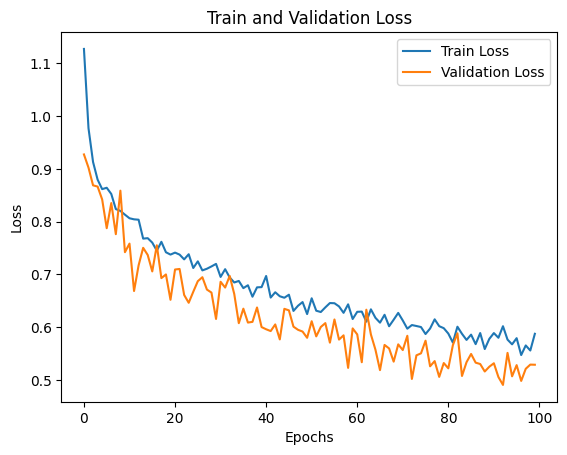

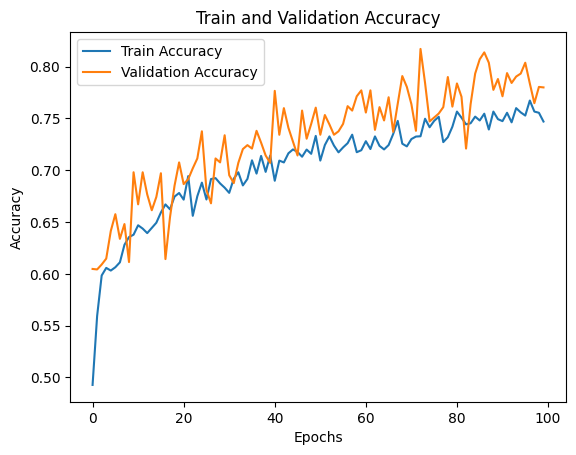

In [ ]:
#plot train and validation loss
plt.figure()
plt.plot(train_loss_epochs, label = "Train Loss")
plt.plot(valid_loss_epochs, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.show()

#plot train and validation accuracy
plt.figure()
plt.plot(train_acc_epochs, label = "Train Accuracy")
plt.plot(valid_acc_epochs, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.show()

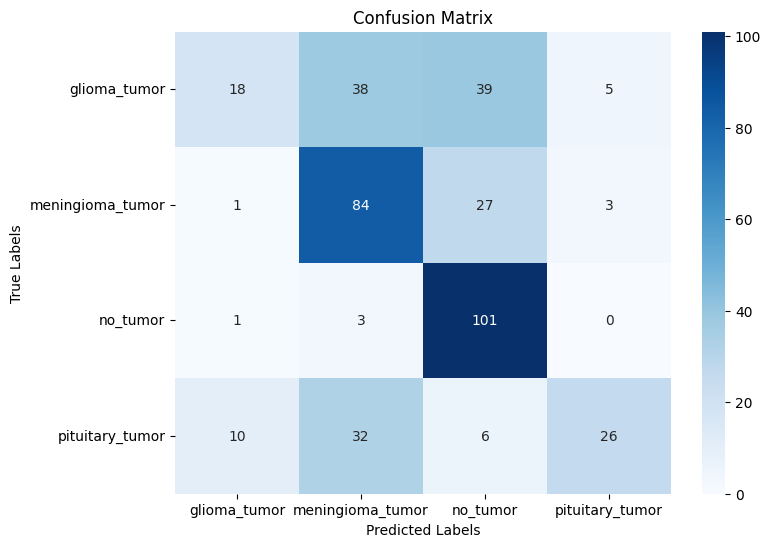

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = []
y_pred_classes = []

class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

alexnet_model.to(device)

for batch in test_loader:
    imgs, labels = batch
    imgs_gray = torch.mean(imgs, dim=1, keepdim=True)
    imgs_gray = imgs_gray.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        logits = alexnet_model(imgs_gray)
    pred_classes = logits.argmax(dim=-1)
    class_labels.extend(labels.cpu().numpy())
    y_pred_classes.extend(pred_classes.cpu().numpy())

conf_matrix = confusion_matrix(class_labels, y_pred_classes, labels=range(len(class_names)))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#print alexnet model so architecture can be explored.
print(alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 